In [1]:
from sklearn.metrics.pairwise import euclidean_distances 
import tensorflow as tf
import numpy as np
import math
dtype=tf.float64

def time_kernel(X1,X2,l1,sig1):
#     x1=np.delete(X1,time_axis-1,1)
#     x2=np.delete(X2,time_axis-1,1)
#     col=X1.shape[1]
    
#     x1=X1[:,:col-1]
#     x2=X2[:,:col-1]
    x1=tf.expand_dims(X1/l1,1)
    x2=tf.expand_dims(X2/l1,0)
    sub1=tf.square(x1-x2)
    r1=tf.reduce_sum(sub1,axis=-1)
    k1=sig1  * tf.exp(-0.5 * r1)
    
    return k1

# def time_kernel1(X1,X2,l1,l2,sig1,sig2):
# #     x1=np.delete(X1,time_axis-1,1)
# #     x2=np.delete(X2,time_axis-1,1)
#     col=X1.shape[1]
    
#     x1=X1[0::10,:col-1]
#     x2=X2[0::10,:col-1]
#     x1=tf.expand_dims(x1/l1,1)
#     x2=tf.expand_dims(x2/l1,0)
#     sub1=tf.square(x1-x2)
#     r1=tf.reduce_sum(sub1,axis=-1)
#     k1=sig1  * tf.exp(-0.5 * r1)
    
#     t1=X1[:10,col-1:]
#     t2=X2[:10,col-1:]
#     t1=tf.expand_dims(t1/l2,1)
#     t2=tf.expand_dims(t2/l2,0)
#     sub2=tf.abs(t1-t2)
#     r2=tf.reduce_sum(sub2,axis=-1)
#     a=np.sqrt(3)
#     k2=sig2*(1.0+a*r2)*tf.exp(-a*r2)
    
#     return k1,k2

class time_GPmodel():
    def __init__(self,data,kernel,l1,sig1,likvar=0.1):
        self.X = data[0]
        self.Y = data[1]
        self.sigma2 = likvar
        self.kern = lambda X1,X2: kernel(X1,X2,l1,sig1)
    def coeff_creation(self):
        # K=self.kern.K(self.X,self.X)+self.sigma2*tf.eye(self.X.shape[0],self.X.shape[0],dtype=tf.float64)
        K=self.kern(self.X,self.X)+self.sigma2*tf.eye(self.X.shape[0],self.X.shape[0],dtype=tf.float64)
        L=tf.linalg.cholesky(K)
        trm1=tf.linalg.triangular_solve(L,self.Y,lower=True)
        self.coeffmu=tf.linalg.triangular_solve(tf.transpose(L),trm1,lower=False)
        trm2=tf.linalg.triangular_solve(L,tf.eye(self.X.shape[0],self.X.shape[0],dtype=tf.float64),lower=True)
        self.coeffvar=tf.linalg.triangular_solve(tf.transpose(L),trm2,lower=False)
    def predict(self,Xtst,with_var=False):
        Kstar=self.kern(Xtst,self.X)
        Kstarstar=self.kern(Xtst,Xtst)
        mu=tf.matmul(Kstar,self.coeffmu)
        if with_var:
            var=tf.linalg.diag_part(Kstarstar)
            var-=tf.matmul(tf.matmul(Kstar,self.coeffvar),tf.transpose(Kstar))
            var+=self.sigma2
            return mu,var
        else:
            return mu

C:\Users\Yuzhang Ge\anaconda3\envs\newenv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow_probability as tfp
tfd = tfp.distributions 

def LogLik(Xtst,Ytst,models,cov):
    pred=models.predict(Xtst)
#     scale = tf.linalg.cholesky(cov)
#     loglik=tf.reduce_sum(tfd.MultivariateNormalTriL(loc=pred,scale_tril=scale).log_prob(Ytst))
    loglik=tf.reduce_sum(tfd.Normal(loc=pred,scale=1.0).log_prob(Ytst))
    return loglik

def PriorMaker(min,max):
    def prior(a,b):
        apr=tfd.Uniform(np.float64(min[0]),np.float64(max[0])).log_prob(a)
        bpr=tfd.Uniform(np.float64(min[1]),np.float64(max[1])).log_prob(b)
#         cpr=tfd.Uniform(np.float64(min[2]),np.float64(max[2])).log_prob(c)
#         dpr=tfd.Uniform(np.float64(min[3]),np.float64(max[3])).log_prob(d)
        # sigpr=tfd.InverseGamma(np.float64(0.001),np.float64(0.001)).log_prob(sig)
        return tf.reduce_sum(apr+bpr)
    return prior

def target(a,b,Ytst,cov,models,prior):
#     A=tf.concat([a]*10,axis=0)
#     B=tf.concat([b]*10,axis=0)
#     C=tf.concat([c]*10,axis=0)
#     D=tf.concat([d]*10,axis=0)
    x=tf.concat([a,b],axis=1)
    lik=LogLik(x,Ytst,models,cov)
    pr=prior(a,b)
    return tf.reduce_sum(lik)

In [3]:
import pickle 
file1 = open('X_time_2000', 'rb')
file2 = open('Y_time_2000', 'rb')
X=pickle.load(file1)
file1.close()
Y=pickle.load(file2)
file2.close()

X1=X[9::10,:2]
Y1=Y[9::10]

train_x=X1[:1200,:]
train_y=Y1[:1200]

In [12]:
np.where((X1[1200:1300,0]>4.0) & (X1[1200:1300,1]<1.0))

(array([20, 52, 76], dtype=int64),)

In [18]:
data=[train_x,train_y]
M=time_GPmodel(data,time_kernel,l1=[0.5330548 , 7.72537898],sig1=228665.32677421535)
M.coeff_creation()

In [19]:
testx=X1[1200:,:]
testy=Y1[1200:]
mean=M.predict(testx)

In [32]:
testx[20]

array([4.47993579, 0.85641357])

In [33]:
from sklearn.metrics import r2_score
print(r2_score(testy,mean))

0.9999998127980289


In [49]:
test_y=Y1[1220:1221,:].reshape((-1,1))
test_x=X1[1220:1221,:]

# cov=np.float64([[0.2,48.62,48.62],
#                 [48.62,0.2,48.62],
#                 [48.62,48.62,0.2]])
cov=np.float64(1.0) 

In [50]:
test_x

array([[4.47993579, 0.85641357]])

In [51]:
min=np.float64([0.1,0.1])
max=np.float64([5,5])
# min=np.float64([[0.1,0.1,0.1,0.1],[0.1,0.1,0.1,0.1]])
# max=np.float64([[10,10,10,10],[10,10,10,10]])

prior=PriorMaker(min,max)

In [52]:
Posterior=lambda a,b: target(a=a,b=b,Ytst=test_y,cov=cov,models=M,prior=prior)
def BijectionMaker(min,max,log):
    bij=[]
    if log:
        for i in range(2):
            bij.append(tfb.Chain([tfb.Log(),tfb.Sigmoid(low=min[i],high=max[i])]))
    else:
        for i in range(2):
            bij.append(tfb.Shift(tf.cast(min[i],tf.float64))(tfb.Scale(tf.cast((max[i])-(min[i]),tf.float64))( tfb.Reciprocal()(
                tfb.Shift(tf.cast(1.,tf.float64))(
                  tfb.Exp()(
                    tfb.Scale(tf.cast(-1.,tf.float64))))))))
    # bij.append(tfb.Exp())
    return bij

In [53]:
tfb=tfp.bijectors
bijector=BijectionMaker(min,max,0)

def step_size_setter_fn(kernel_results, new_step_size):
    pars=kernel_results.inner_results
    pars=pars._replace(
            step_size=new_step_size)
    return kernel_results._replace(
            inner_results=pars)


def step_size_getter_fn(kernel_results):
    return tf.cast(ss, dtype)# for ss in kernel_results.inner_results.step_size]


def log_accept_prob_getter_fn(kernel_results):
    return kernel_results.inner_results.log_accept_ratio

def NutsAdaptiveKernel(FinalTarget,nburn,BIJ):
    nuts=tfp.mcmc.NoUTurnSampler(
    target_log_prob_fn=FinalTarget,
    step_size=tf.cast(0.01,tf.float64),max_tree_depth=11)
    TransNuts= tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=nuts,
    bijector=BIJ)
    return tfp.mcmc.DualAveragingStepSizeAdaptation(
    TransNuts,
    num_adaptation_steps=int(nburn*0.8),
    step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
            inner_results=pkr.inner_results._replace(step_size=new_step_size)),
    step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
    log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio,
    target_accept_prob=tf.cast(.9, dtype),
    decay_rate=tf.cast(.75, dtype)
)


In [54]:
nb=5000
ns=5000
num_chains=2
kernel=NutsAdaptiveKernel(Posterior,nb,bijector)
IniState=[]
for i in range(2):
    IniState.append(tf.Variable(np.float64([[1]])))

IniState[0].assign(np.random.uniform(0.1,5,[1,1]))
IniState[1].assign(np.random.uniform(0.1,5,[1,1]))


IniState

[<tf.Variable 'Variable:0' shape=(1, 1) dtype=float64, numpy=array([[0.13546135]])>,
 <tf.Variable 'Variable:0' shape=(1, 1) dtype=float64, numpy=array([[1.11212332]])>]

In [55]:
@tf.function(experimental_compile=True)
def RunNuts(kern,init_state,nburn,nsamp):
    return tfp.mcmc.sample_chain(
    num_results=nsamp+nburn,
    num_burnin_steps=300,
    current_state=init_state,
    trace_fn=None,
    kernel=kern
    )

states=RunNuts(kernel,IniState,nb,ns)
print(np.array(states).shape)

(2, 10000, 1, 1)


In [56]:
test_x[0,:2]

array([4.47993579, 0.85641357])

In [45]:
Samples=np.concatenate([x.numpy().reshape([10000,x.shape[2]]) for x in states],axis=1)
z=np.mean(Samples,axis=0)

In [46]:
z

array([3.71449782, 2.57619673])

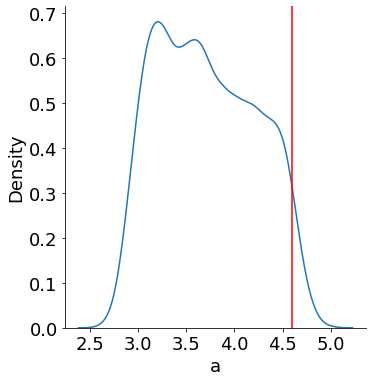

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

p=sns.displot(Samples[:,0],kind="kde",legend=False)
plt.axvline(test_x[0,0],color='red')
p.set_xlabels('a',fontsize=18)
p.set_ylabels(fontsize=18)
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);

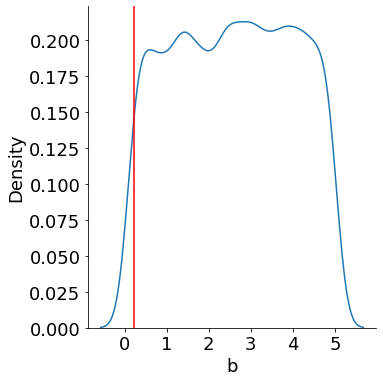

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

p=sns.displot(Samples[:,1],kind="kde",legend=False)
plt.axvline(test_x[0,1],color='red')
p.set_xlabels('b',fontsize=18)
p.set_ylabels(fontsize=18)
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);

In [57]:
import pickle
file1 = open('results/sample_6_1', 'wb')
pickle.dump(Samples, file1)
file1.close()

file2 = open('results/test_6_1', 'wb')
pickle.dump(test_x[0], file2)
file2.close()